In [1]:
import os
import sys

project_root = os.path.abspath(os.path.join(os.getcwd(), "..", ".."))
if project_root not in sys.path:
    sys.path.append(project_root)

In [2]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from img2vec import rgb2emb
import math
import pandas as pd
import joblib
import tensorflow as tf

print("TensorFlow version:", tf.__version__)
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
print("GPU Devices:", tf.config.list_physical_devices('GPU'))

# Set memory growth to avoid taking all GPU memory
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

TensorFlow version: 2.18.0
Num GPUs Available:  0
GPU Devices: []


In [3]:
# Define the batch size
batch_size = 64

### Read the data

In [4]:
train_data = pd.read_csv(os.path.join('..', '..', 'data', 'train.csv'))
val_data = pd.read_csv(os.path.join('..', '..', 'data', 'val.csv'))
test_data = pd.read_csv(os.path.join('..', '..', 'data', 'test.csv'))

### Encode gender labels

In [5]:
# check if the gender_encoder is there
if os.path.exists('gender_encoder.pkl'):
    gender_encoder = joblib.load('gender_encoder.pkl')
    print("gender encoder loaded successfully.")
    
    # Use transform only when encoder is loaded
    train_data['gender_label'] = gender_encoder.transform(train_data['gender'])
    val_data['gender_label'] = gender_encoder.transform(val_data['gender'])
    test_data['gender_label'] = gender_encoder.transform(test_data['gender'])
else:
    gender_encoder = LabelEncoder()
    
    # Fit and transform on training data
    train_data['gender_label'] = gender_encoder.fit_transform(train_data['gender'])
    
    # Then just transform validation and test data
    val_data['gender_label'] = gender_encoder.transform(val_data['gender'])
    test_data['gender_label'] = gender_encoder.transform(test_data['gender'])
    
    # Save after fitting
    joblib.dump(gender_encoder, 'gender_encoder.pkl')
    print("gender encoder saved successfully.")

num_classes = len(gender_encoder.classes_)
print("gender classes:", gender_encoder.classes_)

gender encoder saved successfully.
gender classes: ['f' 'm' 'u']


### Add image paths

In [6]:
def construct_img_path(row):
    return os.path.join("..", "..", "data", "faces", row['user_id'],
                        "coarse_tilt_aligned_face." + str(row['face_id']) + "." + row['original_image'])

train_data['img_path'] = train_data.apply(construct_img_path, axis=1)
val_data['img_path'] = val_data.apply(construct_img_path, axis=1)
test_data['img_path'] = test_data.apply(construct_img_path, axis=1)


### Check if images exist

In [7]:
train_data['img_exists'] = train_data['img_path'].apply(os.path.exists)
val_data['img_exists'] = val_data['img_path'].apply(os.path.exists)
test_data['img_exists'] = test_data['img_path'].apply(os.path.exists)

### Filter out any rows where the image doesn't exist

In [8]:
train_data_filtered = train_data[train_data['img_exists'] == True]
val_data_filtered = val_data[val_data['img_exists'] == True]
test_data_filtered = test_data[test_data['img_exists'] == True]

### Extract image paths and labels

In [9]:
train_image_paths = train_data_filtered['img_path'].tolist()
train_labels = train_data_filtered['gender_label'].values

val_image_paths = val_data_filtered['img_path'].tolist()
val_labels = val_data_filtered['gender_label'].values

test_image_paths = test_data_filtered['img_path'].tolist()
test_labels = test_data_filtered['gender_label'].values

### Define function that process features in batches and store them to avoid recomputation

In [13]:
def preprocess_and_save_features(image_paths, output_file, batch_size=64):
    if os.path.exists(output_file):
        print(f"Loading pre-processed features from {output_file}")
        return np.load(output_file)
    
    print(f"Processing {len(image_paths)} images and saving to {output_file}")
    all_features = []
    
    for i in range(0, len(image_paths), batch_size):
        batch_paths = image_paths[i:i+batch_size]
        print(f"Processing batch {i//batch_size + 1}/{math.ceil(len(image_paths)/batch_size)}")
        batch_features = rgb2emb(batch_paths)
        all_features.append(batch_features)
    
    all_features = np.vstack(all_features)
    np.save(output_file, all_features)
    return all_features

### Process and save features

In [15]:
if not os.path.exists('train_features.npy'):
    train_features = preprocess_and_save_features(train_image_paths, 'train_features.npy')
    val_features = preprocess_and_save_features(val_image_paths, 'val_features.npy')
    test_features = preprocess_and_save_features(test_image_paths, 'test_features.npy')
else:
    train_features = np.load('train_features.npy')
    val_features = np.load('val_features.npy')
    test_features = np.load('test_features.npy')


### Standardize features

In [18]:
if os.path.exists('feature_scaler.pkl'):
    scaler = joblib.load('feature_scaler.pkl')
    print("Feature scaler loaded successfully.")
    
    train_features_scaled = scaler.transform(train_features)
    val_features_scaled = scaler.transform(val_features)
    test_features_scaled = scaler.transform(test_features)
else:
    scaler = StandardScaler()
    train_features_scaled = scaler.fit_transform(train_features)
    val_features_scaled = scaler.transform(val_features)
    test_features_scaled = scaler.transform(test_features)

    # Save the scaler
    joblib.dump(scaler, 'feature_scaler.pkl')
    print("Feature scaler created and saved successfully.")

Feature scaler created and saved successfully.


### Define a simple softmax model 

In [19]:
model = Sequential([
    Dense(num_classes, activation='softmax', input_shape=(train_features.shape[1],),
          kernel_regularizer=tf.keras.regularizers.l2(0.001))
])

model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

c:\Users\shayg\projects\ML\final_project\venv\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_1 (Dense)                 │ (None, 3)              │         6,147 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,147 (24.01 KB)

 Trainable params: 6,147 (24.01 KB)

 Non-trainable params: 0 (0.00 B)

### Train the model

In [20]:
print("Training the model...")
class_weights = compute_class_weight('balanced', classes=np.unique(train_labels), y=train_labels)
class_weight_dict = dict(zip(np.unique(train_labels), class_weights))

# Define the early stopping callback before training the model
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',      # Monitor validation loss
    patience=5,              # Number of epochs with no improvement after which training will stop
    restore_best_weights=True  # Restore model weights from the epoch with the best value of the monitored quantity
)


# Then in model.fit:
history = model.fit(
    train_features_scaled, train_labels,
    validation_data=(val_features_scaled, val_labels),
    epochs=30,
    batch_size=batch_size,
    class_weight=class_weight_dict,
     callbacks=[early_stopping]
)

Training the model...
Epoch 1/30
186/186 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6346 - loss: 0.7714 - val_accuracy: 0.7895 - val_loss: 0.5609
Epoch 2/30
186/186 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8026 - loss: 0.4207 - val_accuracy: 0.8259 - val_loss: 0.4824
Epoch 3/30
186/186 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8352 - loss: 0.3534 - val_accuracy: 0.8505 - val_loss: 0.4217
Epoch 4/30
186/186 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8653 - loss: 0.2972 - val_accuracy: 0.8529 - val_loss: 0.4185
Epoch 5/30
186/186 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8793 - loss: 0.2687 - val_accuracy: 0.8539 - val_loss: 0.4024
Epoch 6/30
186/186 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8911 - loss: 0.2428 - val_accuracy: 0.8607 - val_loss: 0.3878
Epoch 7/30
186/186 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8987 - loss: 0.2253 - val_accuracy: 0.8583 - val_loss: 0.3931
Epoch 8/30
186/186 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9026 - loss: 0.2

### Save the model

In [21]:
model.save('softmax_gender_classifier.h5')
print("Model saved successfully.")

Model saved successfully.


### Evaluate the model

In [22]:
print("Evaluating the model on test data...")
test_loss, test_acc = model.evaluate(test_features_scaled, test_labels)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")

Evaluating the model on test data...
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8010 - loss: 0.5415
Test Loss: 0.5862
Test Accuracy: 0.7992


### Get predictions

In [23]:
test_predictions = model.predict(test_features_scaled)
test_pred_classes = np.argmax(test_predictions, axis=1)

117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


### Visualize results

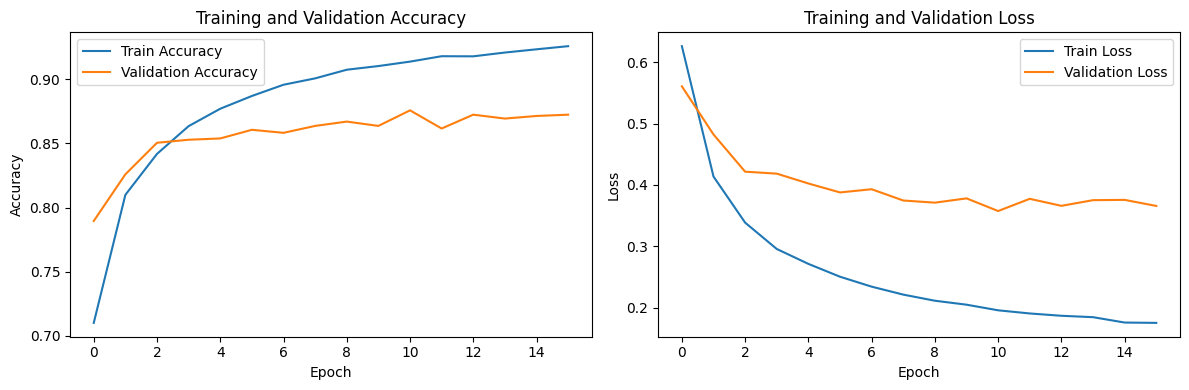

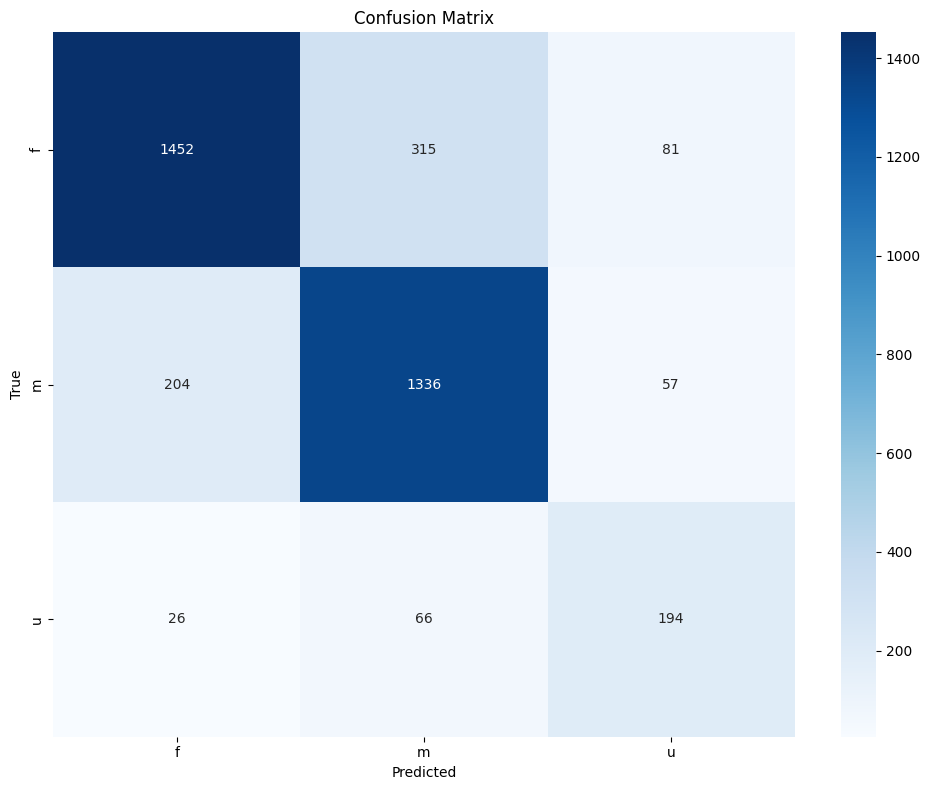

In [24]:
# Plot training history
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')

plt.tight_layout()
plt.savefig('training_history.png')
plt.show()

# Confusion matrix
plt.figure(figsize=(10, 8))
cm = confusion_matrix(test_labels, test_pred_classes)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=gender_encoder.classes_,
            yticklabels=gender_encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.savefig('confusion_matrix.png')
plt.show()

### Classification report

In [25]:
print("Classification Report:")
print(classification_report(test_labels, test_pred_classes, target_names=gender_encoder.classes_))


Classification Report:
              precision    recall  f1-score   support

           f       0.86      0.79      0.82      1848
           m       0.78      0.84      0.81      1597
           u       0.58      0.68      0.63       286

    accuracy                           0.80      3731
   macro avg       0.74      0.77      0.75      3731
weighted avg       0.81      0.80      0.80      3731



### Example of using the model

Model loaded successfully.
gender encoder loaded successfully.
Feature scaler loaded successfully.
Using sample image: ..\..\data\faces\115321157@N03\coarse_tilt_aligned_face.1744.12111738395_a7f715aa4e_o.jpg
Extracting features from ..\..\data\faces\115321157@N03\coarse_tilt_aligned_face.1744.12111738395_a7f715aa4e_o.jpg...
Standardizing features...
Making prediction...
Predicted gender: m with confidence 0.96


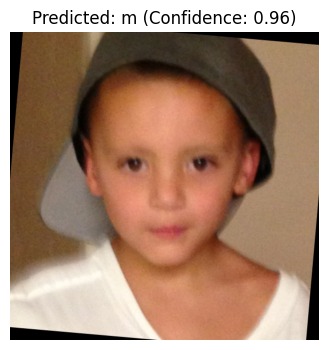


Code for making predictions on new images:


In [26]:
# Load the trained model
model = tf.keras.models.load_model('softmax_gender_classifier.h5')
print("Model loaded successfully.")

# Load the LabelEncoder
gender_encoder = joblib.load('gender_encoder.pkl')
print("gender encoder loaded successfully.")

# Load the scaler
scaler = joblib.load('feature_scaler.pkl')
print("Feature scaler loaded successfully.")

def predict_gender(image_path, model, gender_encoder, scaler):
    """
    Predict the gender range for a given face image.
    
    Parameters:
    image_path (str): Path to the image file
    model: Trained Keras model
    gender_encoder: Trained LabelEncoder for gender classes
    scaler: Trained StandardScaler for feature normalization
    
    Returns:
    tuple: (predicted_gender, confidence)
    """
    # Check if file exists
    if not os.path.exists(image_path):
        print(f"Error: File {image_path} not found")
        return None, 0
        
    # Extract features
    print(f"Extracting features from {image_path}...")
    features = rgb2emb([image_path])
    
    # Check if feature extraction was successful
    if features.size == 0:
        print("Error: Feature extraction failed")
        return None, 0
        
    # Standardize features
    print("Standardizing features...")
    features_scaled = scaler.transform(features)
    
    # Make prediction
    print("Making prediction...")
    pred_probs = model.predict(features_scaled, verbose=0)[0]
    
    # Get predicted class
    pred_class = np.argmax(pred_probs)
    
    # Convert to gender range
    pred_gender = gender_encoder.classes_[pred_class]
    confidence = pred_probs[pred_class]

    return pred_gender, confidence

# Example usage with a sample image
# Replace with an actual path to test
sample_image_path = test_image_paths[0]  # Using the first test image as an example
print(f"Using sample image: {sample_image_path}")

# Make prediction
pred_gender, confidence = predict_gender(sample_image_path, model, gender_encoder, scaler)

if pred_gender is not None:
    print(f"Predicted gender: {pred_gender} with confidence {confidence:.2f}")
    
    # Display the image if possible
    try:
        from PIL import Image
        img = Image.open(sample_image_path)
        plt.figure(figsize=(4, 4))
        plt.imshow(img)
        plt.title(f"Predicted: {pred_gender} (Confidence: {confidence:.2f})")
        plt.axis('off')
        plt.show()
    except Exception as e:
        print(f"Could not display image: {e}")

print("\nCode for making predictions on new images:")